**Starbucks Locations**
============


This is a simple data exploration exercise of the Starbucks Locations data set.
Some questions that are addressed are:

* Which cities have the highest density of Starbucks stores?
* How many Starbucks stores are within 10km of my house?
* Which Starbucks store is the furthest away from my house?

In [97]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [11]:
data_starbucks = pd.read_csv('Starbucks Locations.csv')

### An initial look at the data

In [12]:
data_starbucks.shape    # 13 variables on 25600 stores

(25600, 13)

In [13]:
data_starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


How many missing values are there?

In [14]:
# How many NaNs in each column?
data_starbucks.isnull().sum()    # Data are pretty clean for the most part.

Brand                0
Store Number         0
Store Name           0
Ownership Type       0
Street Address       2
City                15
State/Province       0
Country              0
Postcode          1522
Phone Number      6861
Timezone             0
Longitude            1
Latitude             1
dtype: int64

The data are pretty clean. I don't care much about postal codes or phone numbers.

### Which countries have the most Starbucks stores?

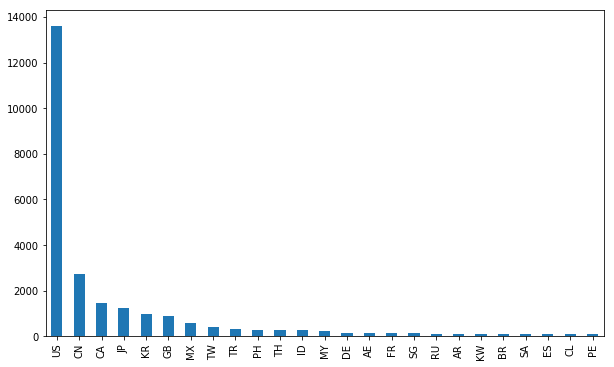

In [64]:
plt.figure(figsize=(10,6))
data_starbucks['Country'].value_counts()[:25].plot('bar')
plt.show()

USA, China, Canada, Japan, and Korea are the top 5.

### Which cities have the most Starbucks stores?

In [25]:
data_starbucks['City'].value_counts()[:25]

Shanghai       544
Seoul          379
Beijing        234
New York       232
London         216
Toronto        192
Chicago        180
Mexico City    180
Seattle        156
Las Vegas      156
Houston        154
Istanbul       144
Vancouver      141
San Diego      135
Calgary        130
Singapore      127
Los Angeles    127
Taipei City    126
Jakarta        123
Hangzhou       119
Portland       117
Shenzhen       113
Guangzhou      106
Phoenix        105
Hong Kong      104
Name: City, dtype: int64

Toronto has a lot of Starbucks.
上海市 (#1) is Shanghai, 北京市 (#3) is Beijing
서울 (#14) is Seoul, which actually appears as 'Seoul' in position #2.
杭州市 (#22) is Hangzhou, 深圳市 (#23) is Shenzhen, 广州市 (#25) is Guangzhou.

Let's "translate" these to English:

In [26]:
city_names = {'上海市': 'Shanghai',
              '北京市': 'Beijing',
              '서울': 'Seoul',
              '杭州市': 'Hangzhou',
             '深圳市': 'Shenzhen',
             '广州市': 'Guangzhou'}

data_starbucks = data_starbucks.replace({'City': city_names})
cities_starbucks = data_starbucks['City'].value_counts()

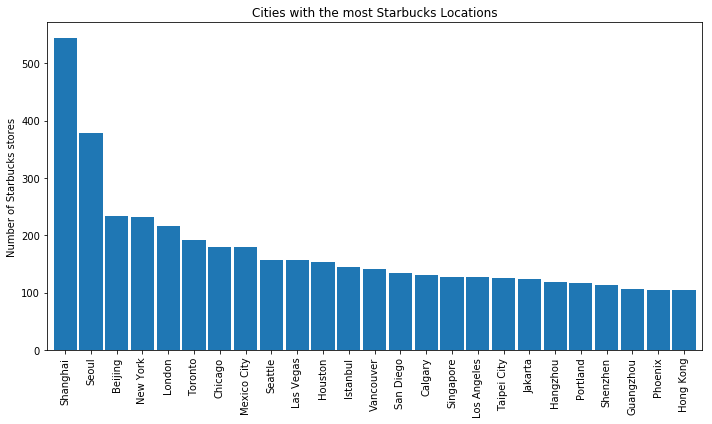

In [63]:
plt.figure(figsize=(10,6))
cities_starbucks[:25].plot('bar', width = 0.9)
plt.title('Cities with the most Starbucks Locations')
plt.ylabel('Number of Starbucks stores')
plt.tight_layout()
plt.show()


### Which cities have the highest Starbucks to people ratio?

We start by loading in population data for world cities. The data come from https://nordpil.com/resources/world-database-of-large-cities/, which I believe uses data from teh UN.

**DISCLAIMER:** The UN data aggregate municipalities into large urban areas, whereas the Starbucks data list their store locations by municipality (i.e., the number of Starbucks locations per urban area are underestimated). 

Example:Mississauga and Hamilton fall under the 'Toronto' urban area in the UN data, but are listed separately in the Starbucks data.


In [45]:
data_populations = pd.read_csv("World City Populations.csv", encoding='latin1')
data_populations.iloc[10:16]

,ID,City,City_Alternate,Country,Latitude,Longitude,Country_ISO3,pop1950,pop1955,pop1960,...,pop1980,pop1985,pop1990,pop1995,pop2000,pop2005,pop2010,pop2015,pop2020,pop2025
10,Calgary,NaN,Canada,51.03,-114.04,CAN,130,190,260,320,...,660,740,810,950,1060,1110,1180,1260,1300,1345
11,Edmonton,NaN,Canada,53.55,-113.50,CAN,160,230,320,390,...,760,830,860,920,1020,1060,1110,1170,1220,1256
12,Montral,Montreal,Canada,45.54,-73.65,CAN,1340,1650,2030,2370,...,2900,3150,3300,3470,3600,3680,3780,3910,4010,4108
13,Ottawa-Gatineau,Ottawa,Canada,45.37,-75.65,CAN,280,340,420,480,...,800,920,990,1080,1120,1140,1180,1230,1270,1315
14,Toronto,NaN,Canada,43.72,-79.41,CAN,1070,1360,1740,2090,...,3360,3810,4200,4610,5040,5210,5450,5690,5830,5946
15,Vancouver,NaN,Canada,49.27,-122.96,CAN,560,590,620,840,...,1360,1560,1790,1960,2090,2150,2220,2310,2380,2444


There is some messiness in the data. The coordinates and Country are mixed up, for example.

What I am more concerend about is that many observations NaNs in the place of the city. That's because if the City name is the same as the ID name, City is NaN.

In [46]:
# If the City variable is NaN, replace it with the value in the ID variable
mask_nulls = data_populations['City'].isnull()
data_populations.loc[mask_nulls, 'City'] = data_populations.loc[mask_nulls, 'ID']

data_populations = data_populations.set_index('City')

In [47]:
# Number of stores / population of the city
density_starbucks = cities_starbucks / \
                    data_populations.loc[cities_starbucks.keys()]['pop2015']

# Some cities not included in population data, or have incompatible characters
density_starbucks = density_starbucks[density_starbucks.notnull()]

# Population data are in 1000s, multiply by 100 to express as stores per 100,000
density_starbucks = density_starbucks * 100

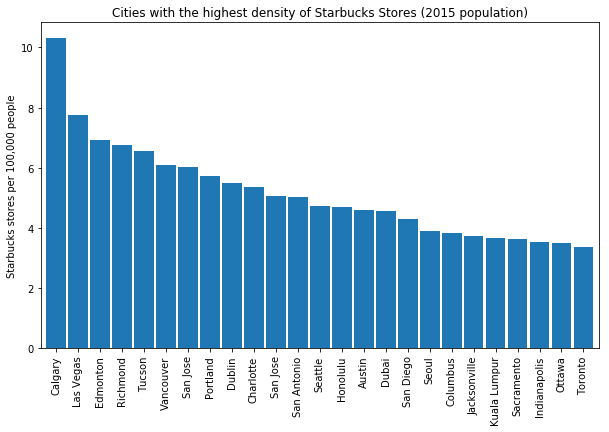

In [62]:
plt.figure(figsize=(10,6))
density_starbucks.sort_values(ascending = False)[:25].plot('bar', width=0.9)
plt.title('Cities with the highest density ' +
          'of Starbucks Stores (2015 population)')
plt.ylabel('Starbucks stores per 100,000 people')
plt.show()

Calgary is apparently the hippest place on Earth.

## Plotting Starbucks Locations

I am implementing a Coordinate class. The main purpose of this is to easily calculate Great Circle distances between two GPS coordinates using the Haversine formula.

In [66]:
class Coordinate(object):
	def __init__(self, lon, lat):
		self.lat = lat
		self.lon = lon

	def __str__(self):
		return '(' + str(self.lat) + ', ' + str(self.lon) + ')'

	def __sub__(self, other):
		# Implement Haversine Formula to calculate distance between two GPS
		# coordinates. Assumes spherical Earth. Units are in km.

		# Convert degree coordinates to radians
		deg_to_rad = math.pi / 180    # Degrees to radian conversion factor
		phi1 = self.lat * deg_to_rad
		phi2 = other.lat * deg_to_rad
		d_phi = (self.lat - other.lat) * deg_to_rad
		d_lambda = (self.lon - other.lon) * deg_to_rad

		# Haversine formula
		alpha = math.sin(d_phi/2)**2 \
		        + math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda/2)**2
		c = 2 * math.atan2(alpha**0.5, (1 - alpha)**0.5)
		d = 6370.997 * c    # 6370.997km = Earth's radius
		return d


In [67]:
data_starbucks['GPS'] = \
	data_starbucks.apply(lambda row:
                         Coordinate(row['Longitude'], row['Latitude']),
                         axis = 'columns'
                         )

### Here are some examples of stupid stuff you can do:

#### How many stores are within ___km of my house?

In [105]:
km = 10
my_house = Coordinate(-79.40, 43.66)

data_starbucks['dist'] = data_starbucks.apply(
	lambda row: my_house - row['GPS'],
	axis = 'columns')

print("Number of stores:")
print(data_starbucks[data_starbucks['dist'] <= km].shape[0])

Number of stores:
159


**Answer:** Way too many.

#### Which store is nearest to my house?

In [74]:
closest = data_starbucks.sort_values('dist').head(1)
print(closest)

          Brand Store Number              Store Name Ownership Type  \
1598  Starbucks    4312-1520  205 College at Beverly  Company Owned   

     Street Address     City State/Province Country Postcode    Phone Number  \
1598    205 College  Toronto             ON      CA  M5T 1P9  (416) 341-0101   

                       Timezone  Longitude  Latitude             GPS  dist  
1598  GMT-05:00 America/Toronto      -79.4     43.66  (43.66, -79.4)   0.0  


**Answer:** The one at College and Beverley. 

Fun fact: Starbucks spells the street name incorrectly (both in this data set and on their store's business cards).

#### Which store is furthest away from my house?

In [75]:
furthest = data_starbucks.sort_values('dist', ascending=False).head(1)
print(furthest)

         Brand  Store Number          Store Name Ownership Type  \
290  Starbucks  25286-240412  DFO Spencer Street       Licensed   

                           Street Address       City State/Province Country  \
290  93-161 Spencer Street, 201, 202, 203  Melbourne            VIC      AU   

    Postcode Phone Number                       Timezone  Longitude  Latitude  \
290     3000          NaN  GMT+10:00 Australia/Melbourne     144.95    -37.82   

                  GPS          dist  
290  (-37.82, 144.95)  16268.163397  


**Answer:** The Spencer Street store in Melborne, Australia.

I will have to visit.

## Here are some more useless things you can do:

#### Plot a map of all of the Starbucks Locations around the world

Text(0.5,1,'Starbucks Locations Around The World')

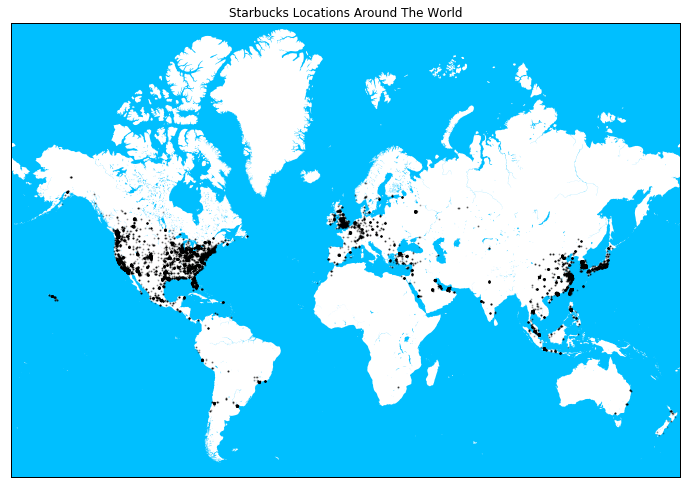

In [98]:
map_resolution = 'i'
plt.figure(figsize=(12, 10))
m = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat=84,\
            llcrnrlon=-180,urcrnrlon=180,resolution=map_resolution)
m.drawmapboundary(fill_color='deepskyblue')
m.fillcontinents(color='white',lake_color='deepskyblue')
# m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
# m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1]
lat, lon = m(np.array(data_starbucks['Longitude']),
             np.array(data_starbucks['Latitude']))
m.plot(lat, lon, 'o', color='k', markersize='1', alpha = 0.25)
plt.title("Starbucks Locations Around The World")

#### How do I get to Melbourne?

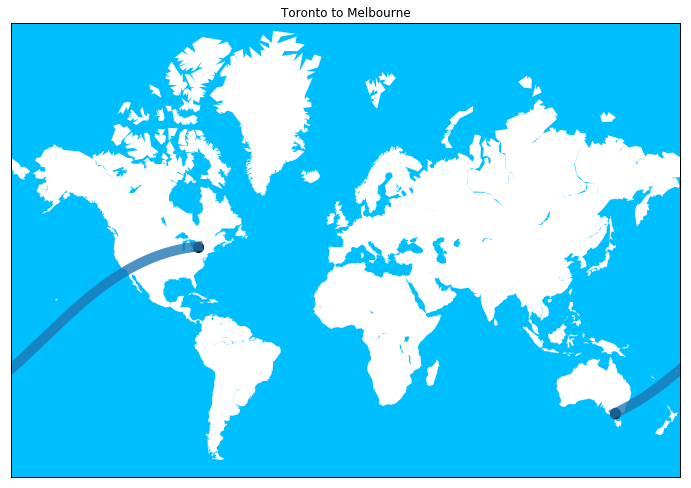

In [104]:
# Coordinates for my nearest store and furthest store
lon1, lat1 = float(closest['Longitude']), float(closest['Latitude'])
lon2, lat2 = float(furthest['Longitude']), float(furthest['Latitude'])

# drawgreatcircle and plot take coordinate data in different forms,
# so need to transform:
x1, y1 = m(lon1, lat1)
x2, y2 = m(lon2, lat2)

plt.figure(figsize=(12, 10))
m = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat=84,\
            llcrnrlon=-180,urcrnrlon=180,resolution=map_resolution)
m.drawmapboundary(fill_color='deepskyblue')
m.fillcontinents(color='white',lake_color='deepskyblue')
# m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
# m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1]
m.plot(x1, y1, 'o', color='k', markersize='10')
m.plot(x2, y2, 'o', color='k', markersize='10')
plt.title("Toronto to Melbourne")

m.drawgreatcircle(lon1, lat1, lon2, lat2, alpha = 0.8, linewidth = 10)